In [16]:
# Install tensorflow_text, if executed in google colab
if 'google.colab' in str(get_ipython()):
  !pip install -q -U "tensorflow-text==2.8.*"

In [17]:
# disable compiler warnings
import os

# imports 
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_text as tf_text
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import Dense
from typing import List
import datetime
from tqdm.notebook import tqdm


from tensorflow.python.client import device_lib
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # FATAL
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Load data

In [18]:
import requests

# Load file from remote, if notebook is executed inside google colab, otherwise it gets loaded from the local file system
if 'google.colab' in str(get_ipython()):
  bible_url = "https://raw.githubusercontent.com/IANNwTF-Group-3/homework10/main/bible.txt"
  response = requests.get(bible_url)
  text = response.text
else:
  file_path = "bible.txt"
  with open(file_path, "r") as f:
      text = f.read()

# Preprocessing

In [19]:
import re

# Lowercase the text
text = text.lower()
# Remove special characters
for c in "!'()*,-.0123456789:;?":
  text = text.replace(c, '')

# Replace new lines and multiple spaces with a single space
text = re.sub('\n', ' ', text)
text = re.sub(' +', ' ', text)
print(text[:197])

the first book of moses called genesis in the beginning god created the heaven and the earth and the earth was without form and void and darkness was upon the face of the deep and the spirit of god


# Tokenize

In [20]:
splitter = tf_text.RegexSplitter()

splitted = splitter.split(text)

tokenizer = tf.keras.preprocessing.text.Tokenizer(
                                                 num_words=10000,
                                                 filters="\n!'()*,-.0123456789:;?",
                                                 lower=True,
                                                 split=' ',
                                                 char_level=False,
                                                 oov_token=None,
                                                 )

tokenizer.fit_on_texts([text])
print(tokenizer.get_config().keys())
print(tokenizer.get_config()['word_index'])
#print(tokenizer.word_counts)

dict_keys(['num_words', 'filters', 'lower', 'split', 'char_level', 'oov_token', 'document_count', 'word_counts', 'word_docs', 'index_docs', 'index_word', 'word_index'])
{"the": 1, "and": 2, "of": 3, "to": 4, "that": 5, "in": 6, "he": 7, "shall": 8, "unto": 9, "for": 10, "i": 11, "his": 12, "a": 13, "lord": 14, "they": 15, "be": 16, "is": 17, "him": 18, "not": 19, "them": 20, "it": 21, "with": 22, "all": 23, "thou": 24, "thy": 25, "was": 26, "god": 27, "which": 28, "my": 29, "me": 30, "said": 31, "but": 32, "ye": 33, "their": 34, "have": 35, "will": 36, "thee": 37, "from": 38, "as": 39, "are": 40, "when": 41, "this": 42, "out": 43, "were": 44, "upon": 45, "by": 46, "you": 47, "man": 48, "israel": 49, "up": 50, "son": 51, "there": 52, "hath": 53, "king": 54, "then": 55, "people": 56, "came": 57, "had": 58, "house": 59, "into": 60, "on": 61, "her": 62, "come": 63, "one": 64, "we": 65, "children": 66, "before": 67, "your": 68, "also": 69, "day": 70, "land": 71, "an": 72, "so": 73, "against

# Create input-taget pairs

In [21]:
word_count = 10000
window_size = 5 # Please use odd number

words = text.split(" ")[:word_count]
input_dataset = []
target_dataset = []
offset = (int) (window_size / 2)
for i in range(offset, word_count - offset):
  for j in range(i - offset, i + offset + 1):
    if j != i:
      input_dataset.append(tokenizer.word_index[words[i]])
      target_dataset.append(tokenizer.word_index[words[j]])

print(words[:10])

dataset = tf.data.Dataset.from_tensor_slices((input_dataset, target_dataset)).batch(32)

['the', 'first', 'book', 'of', 'moses', 'called', 'genesis', 'in', 'the', 'beginning']


# Julians Stuff

In [22]:
"""
vocabulary = {x: i for i, x in enumerate(np.unique(list(text)))}
char_tokens = [vocabulary[char] for char in text]
print(vocabulary)
"""
;

''

In [23]:
"""
sequence_length = 4
dataset = tf.data.Dataset.from_tensor_slices(char_tokens)
dataset = dataset.window(sequence_length,drop_remainder=True)
batch_windows = lambda x: x.batch(sequence_length).get_single_element()
dataset = dataset.map(batch_windows)
dataset = dataset.shuffle(10000).batch(64).prefetch(tf.data.AUTOTUNE)
for seq in dataset.take(1):
    tf.print(seq)
"""
;

''

# SkipGram

In [24]:
class SkipGram(tf.keras.layers.Layer):
    def __init__(self, num_vocabulary, embedding_dim=64):
        super(SkipGram, self).__init__()
        self.v = num_vocabulary
        self.h = embedding_dim
    
    def build(self,_):
        self.embedding_mat = self.add_weight(shape=(self.v, self.h),
                                             initializer="uniform",
                                             trainable=True) 
        self.output_mat = self.add_weight(shape=(self.v, self.h),
                                          initializer="random_normal",
                                          trainable=True) 
        self.output_bias = self.add_weight(shape=(self.v,),
                                           initializer="zero",
                                           trainable=True)

    def call(self, input_id, target_id):
        # (batch,h) = from (v,h) select 'batch_num' v* by lookup
        embedding_vec = tf.nn.embedding_lookup(self.embedding_mat, input_id)

        # compute score vector, softmax of it and loss in one function call
        loss = tf.nn.nce_loss(weights=self.output_mat,  # (v,h)
                              biases=self.output_bias,  # (v,)
                              labels=tf.expand_dims(target_id,axis=1),  # (batch,1)
                              inputs=embedding_vec,  # (batch,h)
                              num_sampled=1,
                              num_classes=self.v)  
        return tf.math.reduce_mean(loss)

    def embedding(self, input_id):
        return tf.nn.embedding_lookup(self.embedding_mat, input_id)

In [25]:
# per batch
def train_step(model, input_batch, target_batch, optimizer):
    with tf.GradientTape() as tape:
        loss = model(input_batch, target_batch)  # call directly returns the loss
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        return loss


In [26]:
LEARNING_RATE = 0.01
BATCH_SIZE = 64
EPOCHS = 20

# define model
skipgram = SkipGram(num_vocabulary=len(tokenizer.word_counts))

# define optimizer
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

# initialize the logger for Tensorboard visualization
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/' + current_time + '/train'    
train_summary_writer = tf.summary.create_file_writer(train_log_dir)

In [27]:
from sklearn.neighbors import NearestNeighbors
def nearest_neighbours(model, num_vocab, selected_word_id, val_dict, k=5):
    cosine_similarity = lambda x,y : np.dot(x,y) / (np.linalg.norm(x) * np.linalg.norm(y))

    # embeddings of words
    embedding_selected_word = skipgram.embedding(tf.constant(selected_word_id))
    embedding_every_word = skipgram.embedding(tf.constant(list(range(num_vocab))))

    # fit nearest neighbours using cosine similarity and embeddings of all words
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto', metric=cosine_similarity)
    nbrs.fit(embedding_every_word)
    # find k_nearest nbrs of selected words. dim:(num_selected, k)
    id_nbrs = nbrs.kneighbors(embedding_selected_word, n_neighbors=k, return_distance=False)
    
    # print neighbours in words instead of id
    for i, sel_w_id in enumerate(selected_word_id):
        query_w = val_dict[sel_w_id]
        neigh_w = []
        for j in range(k):
            neigh_w.append(val_dict[id_nbrs[i,j]])
        print('{} {} most similar words: {}'.format(query_w, k, neigh_w))

Epoch:  0
holy 5 most similar words: ['satisfy', 'backsliding', 'aided', 'dined', 'binnui']
father 5 most similar words: ['grew', 'reward', 'crieth', 'vengeance', 'having']
wine 5 most similar words: ['wicked', 'flee', 'sinners', 'having', 'finish']
poison 5 most similar words: ['surprised', 'snuffers', 'wet', 'nereus', 'displeased']
love 5 most similar words: ['cursing', 'tempered', 'detain', 'afflicted', 'shua']
strong 5 most similar words: ['garnish', 'ascending', 'dalphon', 'kneeling', 'raising']
day 5 most similar words: ['us', 'scribe', 'firstfruit', 'ancestors', 'truth']
 
Epoch:  1
holy 5 most similar words: ['satisfy', 'backsliding', 'aided', 'dined', 'binnui']
father 5 most similar words: ['garment', 'word', 'sinners', 'wicked', 'backward']
wine 5 most similar words: ['garment', 'wicked', 'sinners', 'heel', 'scatter']
poison 5 most similar words: ['surprised', 'snuffers', 'wet', 'nereus', 'displeased']
love 5 most similar words: ['cursing', 'tempered', 'nakedness', 'detain', 

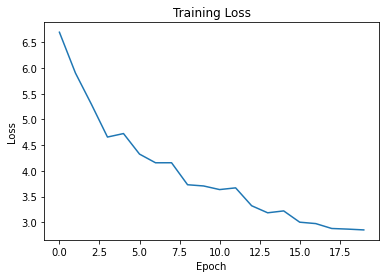

In [28]:
SELECTED_WORDS = [tokenizer.word_index[word] for word in ["holy", "father", "wine", "poison", "love", "strong", "day"]]

import matplotlib.pyplot as plt

epoch_losses = []

for epoch in range(EPOCHS):
    print('Epoch: ', epoch)
    train_losses = []  # each entry is averaged loss of each batch
    # train over all batches

    for input_batch, target_batch in dataset:
        train_losses.append(train_step(skipgram, input_batch, target_batch, optimizer))

    # log train loss
    with train_summary_writer.as_default():  
        tf.summary.scalar('loss', np.mean(train_losses), step=epoch)
    epoch_losses.append(np.mean(train_losses))

    # Nearest neighbours to check embeddings
    nearest_neighbours(skipgram, len(tokenizer.word_counts.keys()), SELECTED_WORDS, tokenizer.index_word)
    print(' ')

plt.plot(epoch_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()